## Imports

In [1]:
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataset import CoconutDataset, collate_fn
from config import Config
from model import Coconut
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import numpy as np

/users/eleves-a/2021/antonin.barbe/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prosqa dataset 

In [2]:
with open(f"data/prosqa_valid.json") as f:
    data = json.load(f)

In [3]:
data[1]

{'question': 'Sally is a zhorpus. Every yumpus is a fompus. Every zhorpus is a rempus. Every rompus is a sterpus. Every kerpus is a timpus. Stella is a yumpus. Every zhorpus is a zumpus. Every wumpus is a yumpus. Sally is a rempus. Stella is a wumpus. Every zumpus is a rorpus. Sally is a rompus. Every numpus is a bompus. Every zumpus is a scrompus. Every rempus is a kerpus. Every zumpus is a vumpus. Every timpus is a yerpus. Every rempus is a numpus. Every vumpus is a worpus. Every rompus is a felpus. Every wumpus is a sterpus. Every rompus is a kerpus. Every zumpus is a rempus. Every rempus is a chorpus. Bob is a rorpus. Every wumpus is a fompus. Sally is a kerpus. Every zhorpus is a rompus. Is Sally a fompus or worpus?',
 'answer': 'Sally is a worpus.',
 'steps': ['Sally is a zhorpus.',
  'Every zhorpus is a zumpus.',
  'Every zumpus is a vumpus.',
  'Every vumpus is a worpus.'],
 'idx_to_symbol': ['Stella',
  'Sally',
  'zhorpus',
  'zumpus',
  'rompus',
  'rempus',
  'wumpus',
  'y

In [4]:
def visualize_prosqa_graph_fixed(data):
    """
    Creates a visualization of a ProSQA dataset sample with enhanced visibility.
    
    Parameters:
    data (dict): A dictionary containing ProSQA dataset item with keys:
                'idx_to_symbol', 'edges', 'steps', 'root', 'target', 'neg_target',
                'question', and 'answer'.
    """
    # Create an undirected graph
    G = nx.Graph()
    
    # Add nodes
    for i, symbol in enumerate(data["idx_to_symbol"]):
        G.add_node(i, label=symbol)
    
    # Add edges
    for source, target in data["edges"]:
        G.add_edge(source, target)
    
    # Extract reasoning path edges
    steps = data["steps"]
    reasoning_path_edges = []
    
    # Get node IDs for the reasoning path
    for i in range(len(steps) - 1):
        current_step = steps[i]
        next_step = steps[i + 1]
        
        # Extract entity names from steps
        current_entity = current_step.split(" is a ")[0]
        current_predicate = current_step.split(" is a ")[1].rstrip(".")
        next_entity = next_step.split(" is a ")[0]
        next_predicate = next_step.split(" is a ")[1].rstrip(".")
        
        # Find node IDs
        if i == 0:  # First step
            source_idx = data["idx_to_symbol"].index(current_entity)
            target_idx = data["idx_to_symbol"].index(current_predicate)
            reasoning_path_edges.append((source_idx, target_idx))
        
        # Connect predicates
        source_idx = data["idx_to_symbol"].index(current_predicate)
        target_idx = data["idx_to_symbol"].index(next_predicate)
        reasoning_path_edges.append((source_idx, target_idx))
    
    # Create a position layout with more spread
    pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)
    
    # Create a figure with white background and larger size
    plt.figure(figsize=(20, 16), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')
    
    # Draw nodes with enhanced visibility
    node_colors = []
    node_sizes = []
    node_borders = []
    border_widths = []
    
    for node in G.nodes():
        if node == data["root"]:  # Root node (Tom)
            node_colors.append("#bdffbd")  # Darker green
            node_sizes.append(5000)
            node_borders.append("black")
            border_widths.append(2.0)
        elif node == data["target"]:  
            node_colors.append("#bdcaff")  
            node_sizes.append(5000)
            node_borders.append("black")
            border_widths.append(2.0)
        elif node == data["neg_target"]:  
            node_colors.append("#DDDDDD") 
            node_sizes.append(5000)
            node_borders.append("#888888")
            border_widths.append(2.0)
        else:
            node_colors.append("#DDDDDD") # Lighter gray
            node_sizes.append(5000)
            node_borders.append("#888888")
            border_widths.append(1.0)
    
    # Draw all edges in light gray with increased width
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color="#AAAAAA")
    
    # Highlight the reasoning path from steps
    reasoning_path = []
    current_node = data["root"]  # Tom
    
    # First, add the direct edge from root to the first step
    first_step = data["steps"][0]
    first_predicate = first_step.split(" is a ")[1].rstrip(".")
    first_predicate_idx = data["idx_to_symbol"].index(first_predicate)
    reasoning_path.append((data["root"], first_predicate_idx))
    
    # Then add edges between consecutive predicates
    for i in range(len(data["steps"]) - 1):
        current_predicate = data["steps"][i].split(" is a ")[1].rstrip(".")
        next_predicate = data["steps"][i+1].split(" is a ")[1].rstrip(".")
        current_predicate_idx = data["idx_to_symbol"].index(current_predicate)
        next_predicate_idx = data["idx_to_symbol"].index(next_predicate)
        reasoning_path.append((current_predicate_idx, next_predicate_idx))
    
    # Draw the reasoning path edges in bold red
    nx.draw_networkx_edges(G, pos, edgelist=reasoning_path, width=3.0, alpha=1, 
                          edge_color="black")
    
    # Draw nodes last so they're on top of the edges
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                          edgecolors=node_borders, linewidths=border_widths)
    
    # Add labels with larger font
    labels = {node: data["idx_to_symbol"][node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=16, 
                           font_color="black")
    
    # Make the legend more visible
    plt.legend(loc="upper right", fontsize=14, frameon=True, 
              facecolor='white', edgecolor='black', title="Legend",
              title_fontsize=16)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the steps text
    plt.axis("off")
    plt.show()

/tmp/ipykernel_1216453/931508297.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=14, frameon=True,


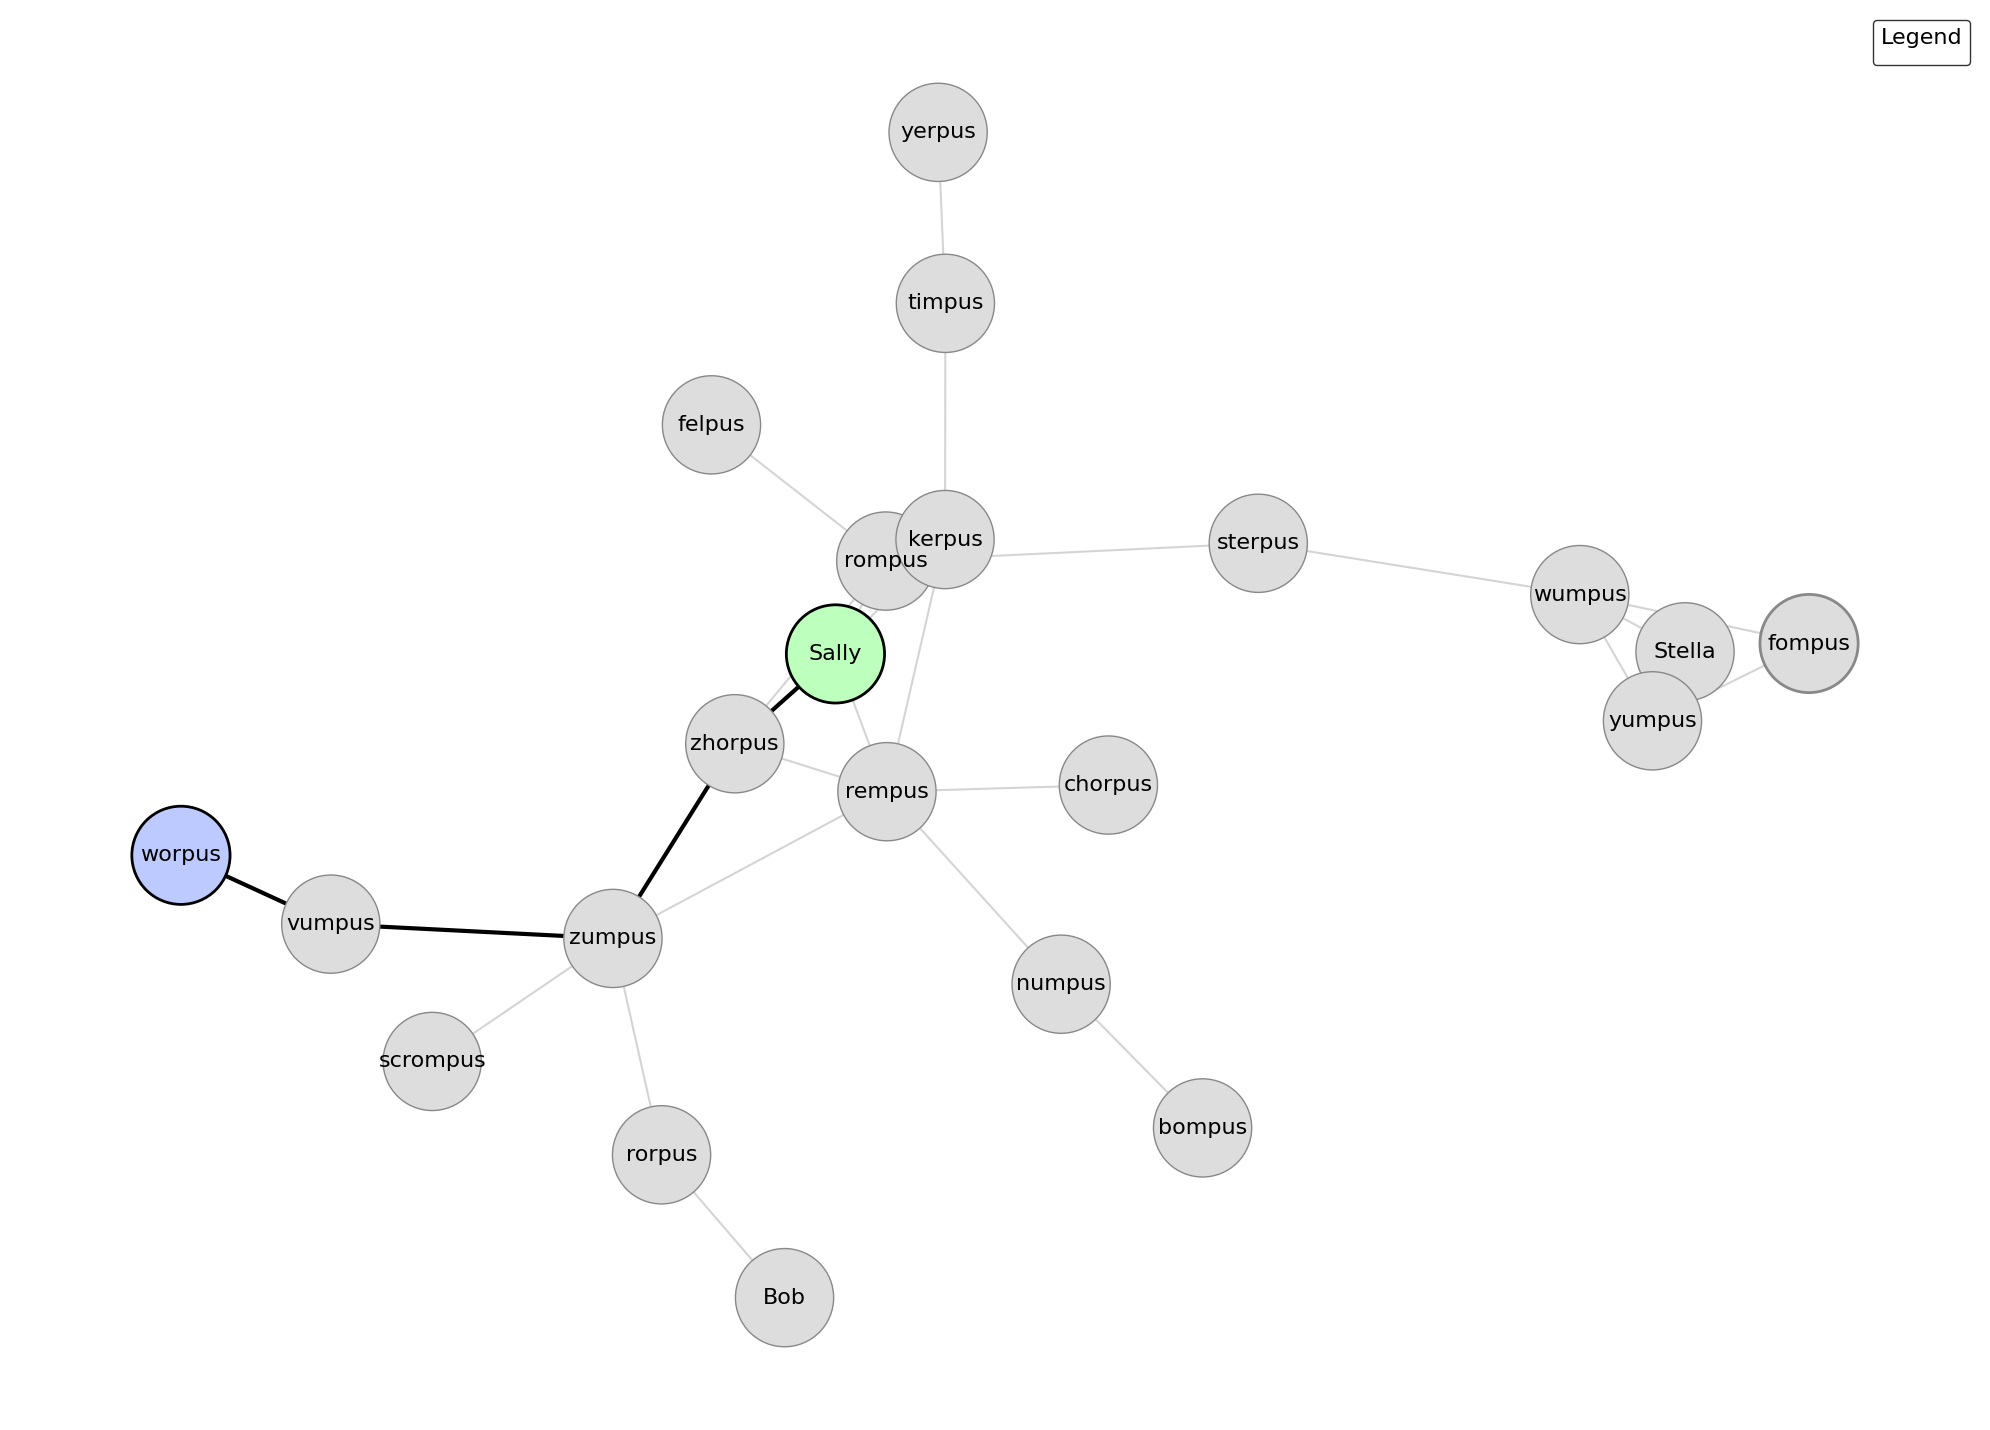

In [5]:
visualize_prosqa_graph_fixed(data[1])

## Coconut

In [7]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens("<|start-latent|>")
tokenizer.add_tokens("<|end-latent|>")
tokenizer.add_tokens("<|latent|>")
latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")
start_id = tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = tokenizer.convert_tokens_to_ids("<|end-latent|>")
model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")
for token_id in [latent_id, start_id, end_id]:
    target_embedding = embeddings.weight.data[target_id]
    embeddings.weight.data[token_id] = target_embedding
model = Coconut(model, latent_id, tokenizer.eos_token_id)

model.load_state_dict(torch.load("/Data/best-prosqa-coconut"))

model.to(Config.device)

/tmp/ipykernel_1216453/1125306014.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Data/best-prosqa-coconut"))


Coconut(
  (base_causallm): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50260, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_featu

In [26]:
dataset_val = CoconutDataset(
        name="prosqa",
        train_or_val="valid",
        modality="coconut",
        stage=3,
        debug = False,
        tokenizer=tokenizer,
        start_id=start_id,
        end_id=end_id,
        latent_id=latent_id,
        c=1,
    )

collate = partial(collate_fn, tokenizer=tokenizer, latent_id=latent_id)
valid_gen_dataloader = torch.utils.data.DataLoader(
    dataset_val,
    num_workers=1,
    pin_memory=True,
    batch_size=1,
    collate_fn=collate,
)

In [27]:
question_val = [
    d["question"] for d in json.load(open(f"data/prosqa_valid.json"))
]
answers_val = [
    d["answer"].replace(",", "").strip()
    for d in json.load(open(f"data/prosqa_valid.json"))
]
cot_val = [
    "\n".join(d["steps"]) for d in json.load(open(f"data/prosqa_valid.json"))
]

In [43]:
correct = torch.tensor(0, device=Config.device)
correct_cot = torch.tensor(0, device=Config.device)
total = torch.tensor(0, device=Config.device)
model.eval()
all_hidden_states = []
with torch.no_grad():
    for batch in tqdm(valid_gen_dataloader):
        test_idx = batch["idx"][0]

        batch = {
            k: v.to(Config.device)
            for k, v in batch.items()
            if v != None and k not in ["idx", "position_ids"]
        }

        answer = answers_val[test_idx.cpu().item()]
        answer_cot = cot_val[test_idx.cpu().item()]
        question = question_val[test_idx.cpu().item()]

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs, hidden_states = model.generate(**batch, max_new_tokens=128, tokenizer=tokenizer, pad_token_id=tokenizer.eos_token_id)
            for h in hidden_states:
                all_hidden_states.append(h.detach().cpu().numpy()[0])

        text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer_output = text_output.split("#")[-1].replace(",", "").strip()
        cot_output = ("\n".join(text_output.split("\n")[1:])).split("#")[0].strip()

        correct += answer_output == answer
        correct_cot += cot_output == answer_cot
        total += 1
        
test_accuracy = correct / total
cot_accuracy = correct_cot / total
print(
        f"Validation accuracy: {test_accuracy:.2f} | CoT validation match: {cot_accuracy:.2f}"
    )


  0%|          | 0/300 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 300/300 [00:47<00:00,  6.36it/s]

Validation accuracy: 0.86 | CoT validation match: 0.00


### Analysis of Latent Variables

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import euclidean


df = pd.DataFrame(all_hidden_states)



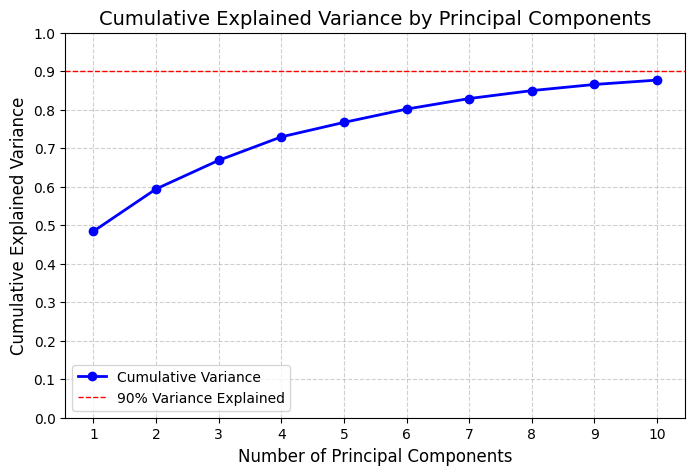

In [140]:

eigenvalues, O = np.linalg.eigh(df.cov())

eigenvalues = eigenvalues[::-1]

cumulative_variance = eigenvalues.cumsum() / eigenvalues.sum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cumulative_variance[:10], marker='o', linestyle='-', color='b', lw=2, label="Cumulative Variance")

plt.axhline(y=0.9, color='r', linestyle='dashed', linewidth=1, label="90% Variance Explained")

plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("Cumulative Explained Variance by Principal Components", fontsize=14)
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [144]:
print('Variance in the first 3 dimensions ',(eigenvalues.cumsum()/eigenvalues.sum())[2])

Variance in the first 3 dimensions  0.6685650922816047


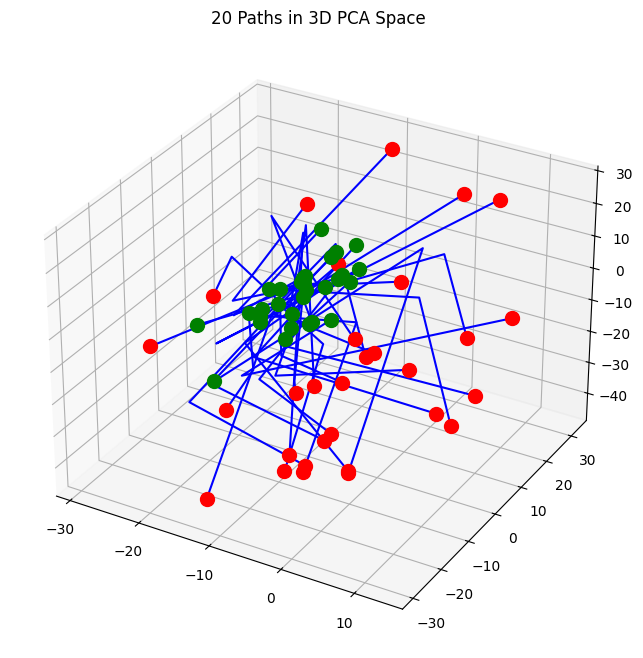

In [145]:



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

path_color = 'b'  

for i in range(30):
    X_pca_3 = (pd.DataFrame(O).iloc[:, -3:].T @ df.T).iloc[:, 3*i:3*i+3].values

    x, y, z = X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2]

    ax.plot(x, y, z, linestyle='-', color=path_color, label=f"Path {i+1}" if i == 0 else "")

    ax.scatter(x[0], y[0], z[0], color='g', s=100, marker='o', label=f"Start {i+1}" if i == 0 else "")
    ax.scatter(x[-1], y[-1], z[-1], color='r', s=100, marker='o', label=f"End {i+1}" if i == 0 else "")


ax.set_title("20 Paths in 3D PCA Space")

plt.show()


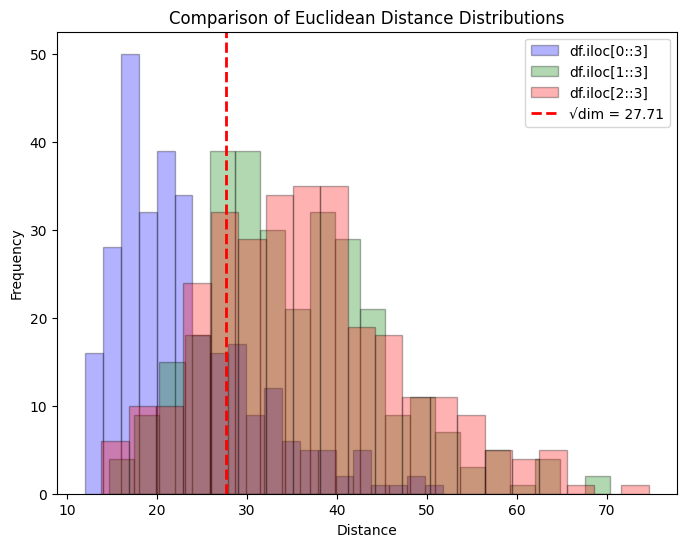

In [ ]:

def compute_distances(df_subset):
    distances = []
    for i in range(len(df_subset) - 1):
        dist = euclidean(df_subset.iloc[i], df_subset.iloc[i+1])
        distances.append(dist)
    return distances

distances_0 = compute_distances(df.iloc[0::3])
distances_1 = compute_distances(df.iloc[1::3])
distances_2 = compute_distances(df.iloc[2::3])

sqrt_dim = np.sqrt(df.shape[1])

plt.figure(figsize=(8,6))

plt.hist(distances_0, bins=20, alpha=0.3, color='blue', edgecolor='black', label='df.iloc[0::3]')
plt.hist(distances_1, bins=20, alpha=0.3, color='green', edgecolor='black', label='df.iloc[1::3]')
plt.hist(distances_2, bins=20, alpha=0.3, color='red', edgecolor='black', label='df.iloc[2::3]')

plt.axvline(sqrt_dim, color='red', linestyle='dashed', linewidth=2, label=f"√dim = {sqrt_dim:.2f}")

plt.title("Comparison of Euclidean Distance Distributions")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


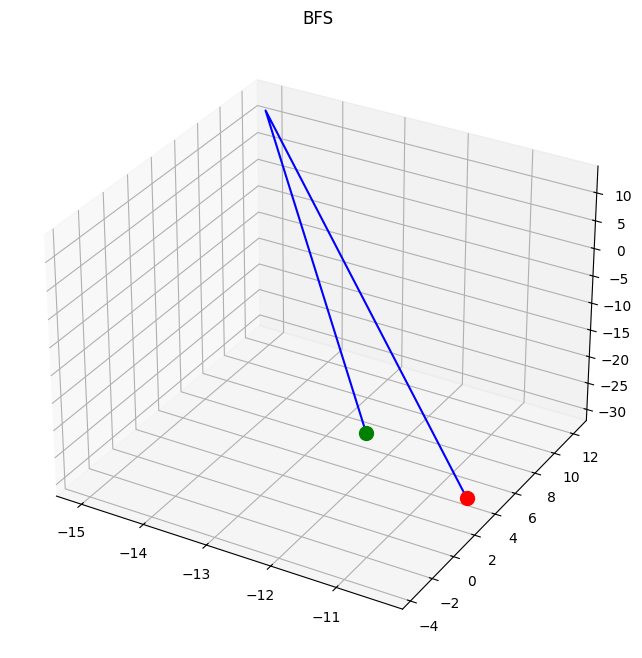

In [ ]:



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

path_color = 'b'  
X_pca_3 = (pd.DataFrame(O).iloc[:, -3:].T @ df.T).iloc[:, 3*2:3*2+3].values
x, y, z = X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2]

ax.plot(x, y, z, linestyle='-', color=path_color, label=f"Path {i+1}" if i == 0 else "")

ax.scatter(x[0], y[0], z[0], color='g', s=100, marker='o', label=f"Start {i+1}" if i == 0 else "")
ax.scatter(x[-1], y[-1], z[-1], color='r', s=100, marker='o', label=f"End {i+1}" if i == 0 else "")


ax.set_title("BFS")

plt.show()

## COT

In [10]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')

model.load_state_dict(torch.load("/users/eleves-b/2021/julien.genzling/best-prosqa-cot"))

model.to(Config.device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)